# Retinal illumination in pseudophakic eyes with and without Negative Dysphotopsia

Supplementary materials to the scientific publication:

> van Vught L, Que I, Luyten GPM, Beenakker JWM. Effect of anatomical differences and intraocular lens design on Negative
> Dysphotopsia. Journal of Cataract & Refractive Surgery: September 06, 2022. doi: 10.1097/j.jcrs.0000000000001054

These supplementary materials consist of:

- Eye models with specific anatomical characteristics for patients with Negative Dysphotopsia and for pseudophakic
controls
- A python script to automatically determine the retinal illumination in Zemax Optic Studio through the ZOSPy API

When using these data/scripts, please cite the above mentioned paper.

The presented code and data are made available for research purposes only, no rights can be derived from them.
These methods has been tested using OpticStudio 2024R1, Python 3.11 and ZOSPy 1.2.1.

Prior to running the script, make sure that the STL files supplied with this script are copied to the OpticStudio
`Objects/CAD Files` folder.

## Included functionalities

* _Non-sequential mode_:
  - Performing non-sequential ray traces.
  - Reading out detector data from a `CAD Part:STL` surface.

## Citation

Next to [citing ZOSPy](/#referencing), please also cite the following paper when using this example or the data provided within this example:

> Vught, L. van, Que, I., Luyten, G.P.M. & Beenakker, J.W.M. (2022).
> Effect of anatomical differences and intraocular lens design on Negative Dysphotopsia.
> Journal of Cataract & Refractive Surgery, 48(12), 1446-1452
> https://doi.org/10.1097/j.jcrs.0000000000001054

## Warranty and liability

The presented code and data are made available for research purposes only. There is no warranty and rights can not be 
derived from them, as is also stated in the general license of this repository.

## Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import zospy as zp

In [2]:
def set_axes_equal_3d(ax):
    """Set equal axis scales for 3D plots.

    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Parameters
    ----------
    ax
        A matplotlib axis, e.g., as output from `plt.gca()`.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

Connect to OpticStudio. Make sure that Zemax OpticStudio in `Interactive Extension` mode (Programming > Interactive Extension).

In [3]:
zos = zp.ZOS()
oss = zos.connect("extension")

Set some variables for the simulations

In [4]:
pachy = 0.55
cornea_iris_distance = 3.12
object_distance = 30  # distance object -> pupil center

Load the models in OpticStudio and run analyses

In [5]:
results = {}

for model in ["NegativeDysphotopsia", "PseudophakicControl"]:
    oss.load(model + "Model.zmx")

    # Get pointers to source and retina objects
    obj_source = oss.NCE.GetObjectAt(2)
    obj_retina = oss.NCE.GetObjectAt(14)

    # Set number of rays
    obj_source.GetCellAt(12).Value = str(1e5)

    first = True  # use this to get position of detectors on first analysis only
    results[model] = {"Irradiance": {}, "AbsorbedIrradiance": {}, "Flux": {}, "AbsorbedFlux": {}}

    for angle in range(0, 165, 5):
        xnew = np.sin(np.deg2rad(angle)) * object_distance
        znew = np.cos(np.deg2rad(angle)) * object_distance
        obj_source.XPosition = xnew
        obj_source.ZPosition = -(znew - pachy - cornea_iris_distance)
        obj_source.TiltAboutY = -angle

        # Trace
        RayTrace = oss.Tools.OpenNSCRayTrace()
        RayTrace.NumberOfCores = 8
        RayTrace.ClearDetectors(0)  # clear the old detector data!
        RayTrace.ScatterNSCRays = True
        RayTrace.UsePolarization = False
        RayTrace.SplitNSCRays = False
        RayTrace.IgnoreErrors = True
        RayTrace.RunAndWaitForCompletion()
        RayTrace.Close()

        # Get data
        fd = obj_retina.GetFacetedObjectData()

        centroids = []
        irradiance = []
        absorbed_irradiance = []
        flux = []
        absorbed_flux = []

        for face_number in range(fd.NumberOfFaces):
            fd.CurrentFace = face_number

            if first:
                vertices = np.array(
                    [list(fd.GetVertex(vertex_number)[1:]) for vertex_number in range(fd.NumberOfVertices)]
                )
                centroids.append(vertices.mean(axis=0))

            irradiance.append(fd.Irradiance)
            absorbed_irradiance.append(fd.AbsorbedIrradiance)
            flux.append(fd.Flux)
            absorbed_flux.append(fd.AbsorbedFlux)

        if first:
            results[model]["Centroids"] = np.array(centroids)
            first = False  # Make sure centroids are only read in once

        results[model]["Irradiance"][angle] = np.array(irradiance)
        results[model]["AbsorbedIrradiance"][angle] = np.array(absorbed_irradiance)
        results[model]["Flux"][angle] = np.array(flux)
        results[model]["AbsorbedFlux"][angle] = np.array(absorbed_flux)

Visualize the results

Text(0.5, 0, 'y')

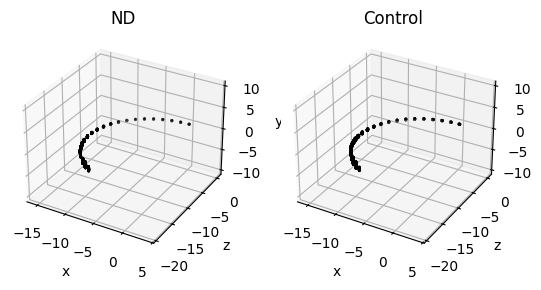

In [6]:
# Show results
cumulative_irradiance_nd = np.array(
    [results["NegativeDysphotopsia"]["Irradiance"][key] for key in results["NegativeDysphotopsia"]["Irradiance"]]
).sum(axis=0)

cumulative_irradiance_co = np.array(
    [results["PseudophakicControl"]["Irradiance"][key] for key in results["PseudophakicControl"]["Irradiance"]]
).sum(axis=0)

fig = plt.figure()
ax1 = fig.add_subplot(121, projection=Axes3D.name)
ax2 = fig.add_subplot(122, projection=Axes3D.name)

vmax = np.max([cumulative_irradiance_nd.max(), cumulative_irradiance_co.max()])
filter_nd = cumulative_irradiance_nd != 0
ax1.scatter(
    *results["NegativeDysphotopsia"]["Centroids"][filter_nd].T[np.array([0, 2, 1])],
    c=cumulative_irradiance_nd[filter_nd],
    cmap="Greys_r",
    vmin=0,
    vmax=vmax,
    s=1,
)

filter_co = cumulative_irradiance_co != 0
ax2.scatter(
    *results["PseudophakicControl"]["Centroids"][filter_co].T[np.array([0, 2, 1])],
    c=cumulative_irradiance_co[filter_co],
    cmap="Greys_r",
    vmin=0,
    vmax=vmax,
    s=1,
)

ax1.set_title("ND")
ax2.set_title("Control")

set_axes_equal_3d(ax1)
set_axes_equal_3d(ax2)

ax1.set_xlabel("x")
ax1.set_ylabel("z")
ax1.set_zlabel("y")

ax2.set_xlabel("x")
ax2.set_ylabel("z")
ax2.set_zlabel("y")